# Resolvendo TSP com Lin-Kerninghan e KP com BitFlip

In [7]:
#Bibliotecas
import time
inicio = time.time() # Inicia o contador de tempo


import pandas as pd
import numpy as np
import re
import subprocess
import math
import random
import matplotlib.pyplot as plt

# Definindo a semente para o gerador de números aleatórios
random.seed(42)

In [8]:
import pandas as pd
import math
import re

# Função para ler o arquivo a partir de uma linha específica
def ler_arquivo_a_partir_da_linha(arquivo, linha_inicial):
    with open(arquivo, 'r') as file:
        linhas = file.readlines()
    cabecalho = linhas[:8]  # primeiras 8 linhas para cabeçalho
    cidades = linhas[9:linha_inicial + 10]  # linhas contendo as cidades
    itens = linhas[linha_inicial + 10:]  # linhas contendo os itens
    return cabecalho, cidades, itens

# Função para ler uma linha específica do arquivo
def ler_linha_especifica(arquivo, numero_linha):
    with open(arquivo, 'r') as file:
        linhas = file.readlines()
    if 1 <= numero_linha <= len(linhas):
        return linhas[numero_linha - 1]

# Função para criar um DataFrame a partir das linhas lidas
def criar_tabela(linhas):
    # Supondo que os dados estejam separados por tabulações
    dados = [linha.strip().split('\t') for linha in linhas]
    df = pd.DataFrame(dados[1:], columns=dados[0])  # Define a primeira linha como cabeçalho
    df = df.apply(pd.to_numeric, errors='ignore')  # Converte para numérico onde possível
    return df

# Caminho do arquivo de texto
arquivo = 'a280_n279.txt'

# Parâmetros
num_cidades = int("".join(filter(str.isdigit, ler_linha_especifica(arquivo, 3))))
n_item = int("".join(filter(str.isdigit, ler_linha_especifica(arquivo, 4))))
capacidade_mochila = int("".join(filter(str.isdigit, ler_linha_especifica(arquivo, 5))))
velocidade_minima = float(re.findall(r'\d+\.\d+', ler_linha_especifica(arquivo, 6))[0])
velocidade_maxima = 1.0
taxa_aluguel_por_tempo = float(re.findall(r'\d+\.\d+', ler_linha_especifica(arquivo, 8))[0])

# Ler o arquivo a partir da linha das cidades
cabecalho, cidades, itens = ler_arquivo_a_partir_da_linha(arquivo, num_cidades)

# Criar DataFrame para cidades
cidades = [linha.replace('NODE_COORD_SECTION	(INDEX, X, Y): ', 'cidade\tx\ty') for linha in cidades]
cidades_df = criar_tabela(cidades)

# Criar DataFrame para itens
itens = [linha.replace('ITEMS SECTION	(INDEX, PROFIT, WEIGHT, ASSIGNED NODE NUMBER): ', 'item\tprofit\tweight\tcidade') for linha in itens]
itens_df = criar_tabela(itens)

# Estrutura para itens associados a cidades
itens = [(int(itens_df['cidade'].iloc[i]), int(itens_df['profit'].iloc[i]), int(itens_df['weight'].iloc[i])) for i in range(len(itens_df))]

# Função para calcular a distância euclidiana entre duas cidades
def calcular_distancia(cidade1, cidade2):
    return math.sqrt((cidade2['x'] - cidade1['x'])**2 + (cidade2['y'] - cidade1['y'])**2)

from scipy.spatial import distance_matrix

# Convertendo as coordenadas das cidades para arrays NumPy
coordenadas = cidades_df[['x', 'y']].values

# Calculando a matriz de distâncias com scipy
distancia_cidades = distance_matrix(coordenadas, coordenadas)

# Coordenadas das cidades para plotagem
coordenadas_cidades = {i: (cidades_df['x'].iloc[i], cidades_df['y'].iloc[i]) for i in range(num_cidades)}



## Lista de Funções

In [9]:

# Função de avaliação: calcula a distância total da rota (iniciando e terminando na cidade 1)
def calcular_distancia_total(rota):
    distancia_total = 0
    for i in range(len(rota) - 1):
        distancia_total += distancia_cidades[rota[i]][rota[i + 1]]
    distancia_total += distancia_cidades[rota[-1]][rota[0]]  # Retorno ao ponto inicial (cidade 1)
    return distancia_total



# Função Lin-Kernighan simplificada com 2-opt swap para melhorar localmente uma rota
def lin_kernighan_2opt(rota_inicial):
    rota_atual = rota_inicial[:]
    melhor_distancia = calcular_distancia_total(rota_atual)
    melhorou = True

    while melhorou:
        melhorou = False
        for i in range(1, len(rota_atual) - 2):
            for j in range(i + 1, len(rota_atual) - 1):
                # Realizar troca (2-opt swap)
                nova_rota = rota_atual[:i] + rota_atual[i:j + 1][::-1] + rota_atual[j + 1:]
                nova_distancia = calcular_distancia_total(nova_rota)
                
                # Se a nova rota for melhor, atualiza a rota atual
                if nova_distancia < melhor_distancia:
                    melhor_distancia = nova_distancia
                    rota_atual = nova_rota[:]
                    melhorou = True
    return rota_atual, melhor_distancia

# Função para o algoritmo híbrido de Simulated Annealing com Lin-Kernighan
def simulated_annealing_lin_kernighan():
    # Inicializa uma rota aleatória
    rota_atual = [0] + random.sample(range(1, num_cidades), num_cidades - 1) + [0]
    distancia_atual = calcular_distancia_total(rota_atual)
    melhor_rota = rota_atual[:]
    melhor_distancia = distancia_atual

    # Parâmetros do Simulated Annealing
    temperatura = 1000
    taxa_resfriamento = 0.97
    temperatura_min = 0.01

    while temperatura > temperatura_min:
        # Gera uma nova rota realizando uma pequena perturbação (2-opt swap)
        i, j = sorted(random.sample(range(1, num_cidades), 2))
        nova_rota = rota_atual[:i] + rota_atual[i:j + 1][::-1] + rota_atual[j + 1:]
        
        # Otimiza a nova rota localmente usando Lin-Kernighan
        nova_rota_otimizada, nova_distancia = lin_kernighan_2opt(nova_rota)

        # Critério de aceitação do Simulated Annealing
        if nova_distancia < distancia_atual or math.exp((distancia_atual - nova_distancia) / temperatura) > random.random():
            rota_atual = nova_rota_otimizada[:]
            distancia_atual = nova_distancia
            
            # Atualiza a melhor solução encontrada
            if distancia_atual < melhor_distancia:
                melhor_rota = rota_atual[:]
                melhor_distancia = distancia_atual

        # Resfriamento
        temperatura *= taxa_resfriamento

    return melhor_rota, melhor_distancia




## Resolvendo TSP

Tempo limite atingido. Encerrando o processo.
Erro ao executar o LKH-3: 
Melhor rota encontrada (iniciando e terminando na cidade 1): [0, 1, 241, 242, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 245, 244, 243, 246, 249, 250, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 208, 251, 254, 253, 252, 207, 206, 205, 204, 203, 202, 201, 199, 143, 144, 198, 197, 200, 195, 194, 193, 196, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 175, 179, 178, 149, 177, 176, 150, 151, 155, 152, 154, 153, 128, 127, 126, 125, 29, 124, 123, 122, 121, 120, 119, 118, 156, 157, 158, 159, 174, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 108, 107, 109, 111, 110, 113, 112, 86, 83, 82, 87, 81, 80, 79, 78, 77, 76, 74, 75, 73, 72, 71, 70, 69, 66, 68, 67, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 58, 62, 63, 

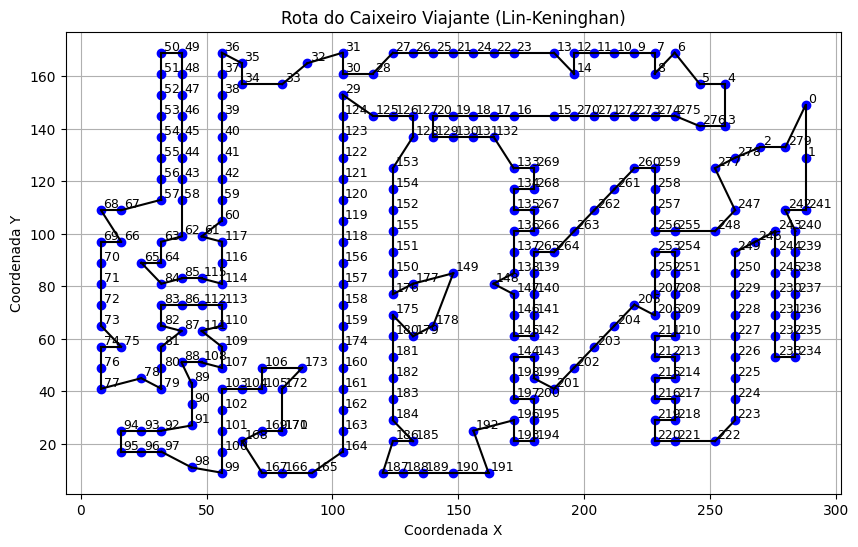

In [10]:
import subprocess
import time
import psutil
import os

def executar_lkh3_forcado(caminho_executavel, arquivo_parametros, timeout=1):
    """
    Executa o LKH-3 e força o encerramento após o timeout usando psutil.
    """
    try:
        # Inicia o subprocesso
        processo = subprocess.Popen(
            [caminho_executavel, arquivo_parametros],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        
        # Aguardar até o timeout
        inicio = time.time()
        while processo.poll() is None:
            if time.time() - inicio > timeout:
                print("Tempo limite atingido. Encerrando o processo.")
                # Obter o processo principal com psutil
                processo_psutil = psutil.Process(processo.pid)
                # Tenta encerrar o processo e todos os subprocessos relacionados
                for proc in processo_psutil.children(recursive=True):
                    proc.terminate()  # Encerra subprocessos primeiro
                processo_psutil.terminate()  # Encerra o processo principal
                time.sleep(1)  # Espera brevemente para garantir o término
                
                # Força o encerramento completo se ainda ativo
                gone, still_alive = psutil.wait_procs([processo_psutil], timeout)
                if still_alive:
                    print("Forçando encerramento completo.")
                    for proc in still_alive:
                        proc.kill()  # Mata qualquer processo ainda ativo
                break
            time.sleep(0.5)  # Aguarda brevemente antes de verificar novamente

        # Captura a saída, caso o processo tenha sido finalizado
        stdout, stderr = processo.communicate()
        if processo.returncode == 0:
            print("LKH-3 finalizado com sucesso.")
            return stdout
        else:
            print("Erro ao executar o LKH-3:", stderr)
            return None
    except Exception as e:
        print("Erro durante a execução:", e)
        return None

# Exemplo de uso
caminho_executavel = "LKH-3.exe"
arquivo_parametros = "param.par"

# Executa o LKH-3 com timeout
executar_lkh3_forcado(caminho_executavel, arquivo_parametros)

#Função de avaliação: calcula a distância total da rota (iniciando e terminando na cidade 1)
def calcular_distancia_total(rota):
    distancia_total = 0
    for i in range(len(rota) - 1):
        distancia_total += distancia_cidades[rota[i]][rota[i + 1]]
    distancia_total += distancia_cidades[rota[-1]][rota[0]]  # Retorno ao ponto inicial (cidade 1)
    return distancia_total


def ler_rota_otimizada(arquivo_saida):
    """
    Função para ler a rota otimizada a partir do arquivo de saída .tour do LKH-3.
    
    Parâmetros:
    arquivo_saida (str): Caminho para o arquivo de saída .tour.
    
    Retorna:
    list: Array com a sequência da rota otimizada.
    """
    rota = []
    try:
        with open(arquivo_saida, 'r') as file:
            leitura = False
            for linha in file:
                # Inicia a leitura ao encontrar "TOUR_SECTION"
                if "TOUR_SECTION" in linha:
                    leitura = True
                    continue
                # Encerra a leitura ao encontrar o marcador "-1"
                if leitura:
                    if linha.strip() == "-1":
                        break
                    # Adiciona o índice da cidade à rota
                    rota.append(int(linha.strip()))
        return rota
    except FileNotFoundError:
        print(f"Erro: o arquivo {arquivo_saida} não foi encontrado.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro ao ler o arquivo: {e}")
        return None

# Arquivos
caminho_executavel = "LKH-3.exe"
arquivo_parametros = "param.par"
arquivo_saida = "rota_otimizada.txt"

rota_otimizada = ler_rota_otimizada(arquivo_saida)

rota_otimizada = rota_otimizada = [rota_otimizada[i]-1 for i in range(len(rota_otimizada))]

# Calcula a distância total da rota otimizada
distancia_otimizada = calcular_distancia_total(rota_otimizada + [rota_otimizada[0]])  # Volta ao ponto inicial

# Exibir a solução encontrada
print("Melhor rota encontrada (iniciando e terminando na cidade 1):", rota_otimizada)
print("Distância total da rota:", distancia_otimizada)


# Plotar as cidades e a rota
plt.figure(figsize=(10, 6))

# Plotar as cidades
for cidade, (x, y) in coordenadas_cidades.items():
    plt.plot(x, y, 'bo')
    plt.text(x + 1, y + 1, f'{cidade}', fontsize=9)

# Plotar a rota
for i in range(len(rota_otimizada) - 1):
    cidade_atual = rota_otimizada[i]
    cidade_proxima = rota_otimizada[i + 1]
    x_coords = [coordenadas_cidades[cidade_atual][0], coordenadas_cidades[cidade_proxima][0]]
    y_coords = [coordenadas_cidades[cidade_atual][1], coordenadas_cidades[cidade_proxima][1]]
    plt.plot(x_coords, y_coords, 'k-')

# Fechar o ciclo da rota
cidade_final = rota_otimizada[-1]
cidade_inicial = rota_otimizada[0]
x_coords = [coordenadas_cidades[cidade_final][0], coordenadas_cidades[cidade_inicial][0]]
y_coords = [coordenadas_cidades[cidade_final][1], coordenadas_cidades[cidade_inicial][1]]
plt.plot(x_coords, y_coords, 'k-')

plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Rota do Caixeiro Viajante (Lin-Keninghan)')
plt.grid(True)
plt.show()




## Resolvendo a Mochila (KP)

In [11]:
# Função para coletar itens e calcular aluguel da mochila, respeitando a cidade inicial e final fixa
def selecionar_itens_e_calcular_aluguel(rota, capacidade_mochila, taxa_aluguel_por_tempo, ponto_coleta=0.8):
    itens_selecionados = []
    peso_total = 0
    valor_total = 0
    distancia_total = 0
    tempo_total = 0
    aluguel_total = 0

    # Constante para ajuste da velocidade
    constante_velocidade = (velocidade_maxima - velocidade_minima) / capacidade_mochila

    # Calcular a relação valor/peso para cada item e ordenar itens de forma decrescente
    itens_ordenados = sorted(itens, key=lambda x: x[1] / x[2], reverse=True)

    # Determinar o ponto de coleta preferencial (80% da rota por padrão)
    limite_coleta = int(len(rota) * ponto_coleta)

    # Função para calcular a velocidade com base no peso total
    def calcular_velocidade(peso):
        velocidade = velocidade_maxima - constante_velocidade * peso
        return max(velocidade, velocidade_minima)  # Limita à velocidade mínima para evitar valores negativos

    # Loop para percorrer cada trecho da rota
    for i in range(len(rota) - 1):
        cidade_atual = rota[i]
        cidade_proxima = rota[i + 1]

        # Coleta itens na cidade atual se ela estiver após o ponto de coleta preferencial
        if i >= limite_coleta:
            for item in itens_ordenados:
                # Verifica se o item pertence à cidade atual e se há capacidade disponível na mochila
                if item[0] == cidade_atual and peso_total + item[2] <= capacidade_mochila:
                    itens_selecionados.append(item)
                    peso_total += item[2]  # Atualiza o peso total com o item recém-coletado
                    valor_total += item[1]  # Atualiza o valor total dos itens coletados

        # Calcular o tempo e o aluguel para o trecho entre `cidade_atual` e `cidade_proxima`
        distancia = distancia_cidades[cidade_atual][cidade_proxima]
        tempo = distancia / calcular_velocidade(peso_total)  # Usa a velocidade com o peso atual
        tempo_total += tempo
        aluguel_total += taxa_aluguel_por_tempo * tempo  # Custo do aluguel para o tempo gasto neste trecho

    # Cálculo do retorno ao ponto inicial (último trecho)
    cidade_final = rota[-1]
    cidade_inicial = rota[0]
    distancia_retorno = distancia_cidades[cidade_final][cidade_inicial]
    tempo_retorno = distancia_retorno / calcular_velocidade(peso_total)
    tempo_total += tempo_retorno
    aluguel_total += taxa_aluguel_por_tempo * tempo_retorno

    # Retorna os resultados finais: lista de itens coletados, valor e peso dos itens, tempo total e aluguel total
    return itens_selecionados, valor_total, peso_total, tempo_total, aluguel_total

# Otimização da mochila com Bit Flip para melhorar os resultados
def otimizar_mochila_bit_flip(itens_selecionados, peso_total, valor_total):
    # Fazer bit flip para maximizar o valor dos itens na mochila
    for item in itens:
        if item in itens_selecionados:
            # Tenta remover o item e verifica se melhora o valor total
            novos_itens = [i for i in itens_selecionados if i != item]
            novo_peso = peso_total - item[2]
            novo_valor = valor_total - item[1]
            if novo_peso <= capacidade_mochila and novo_valor > valor_total:
                itens_selecionados = novos_itens
                peso_total = novo_peso
                valor_total = novo_valor
        else:
            # Tenta adicionar o item e verifica se melhora o valor total
            novo_peso = peso_total + item[2]
            novo_valor = valor_total + item[1]
            if novo_peso <= capacidade_mochila and novo_valor > valor_total:
                itens_selecionados.append(item)
                peso_total = novo_peso
                valor_total = novo_valor

    return itens_selecionados, valor_total, peso_total

# Função para recalcular o tempo e o aluguel com a seleção final de itens
def calcular_tempo_aluguel_com_itens(rota, itens_selecionados, taxa_aluguel_por_tempo):
    peso_total = 0
    tempo_total = 0
    aluguel_total = 0

    # Constante para ajuste da velocidade
    constante_velocidade = (velocidade_maxima - velocidade_minima) / capacidade_mochila

    def calcular_velocidade(peso):
        velocidade = velocidade_maxima - constante_velocidade * peso
        return max(velocidade, velocidade_minima)

    for i in range(len(rota) - 1):
        cidade_atual = rota[i]
        cidade_proxima = rota[i + 1]

        # Atualiza o peso total se itens foram coletados na cidade atual
        for item in itens_selecionados:
            if item[0] == cidade_atual:
                peso_total += item[2]  # Acumula o peso dos itens coletados na cidade

        # Calcula o tempo e o aluguel para o trecho atual com o peso atualizado
        distancia = distancia_cidades[cidade_atual][cidade_proxima]
        tempo = distancia / calcular_velocidade(peso_total)
        tempo_total += tempo
        aluguel_total += taxa_aluguel_por_tempo * tempo

    # Retorno ao ponto inicial
    cidade_final = rota[-1]
    cidade_inicial = rota[0]
    distancia_retorno = distancia_cidades[cidade_final][cidade_inicial]
    tempo_retorno = distancia_retorno / calcular_velocidade(peso_total)
    tempo_total += tempo_retorno
    aluguel_total += taxa_aluguel_por_tempo * tempo_retorno

    return tempo_total, aluguel_total

#Parâmetro coleta
ponto_coleta = 0.935

# Selecionar os itens e calcular o aluguel considerando coleta preferencial no final da rota
itens_selecionados, valor_total, peso_total, _, _ = selecionar_itens_e_calcular_aluguel(
    rota_otimizada, capacidade_mochila, taxa_aluguel_por_tempo, ponto_coleta
)

# Otimizar a mochila usando bit flip
itens_otimizados, valor_itens, peso_itens = otimizar_mochila_bit_flip(itens_selecionados, peso_total, valor_total)

# Recalcular tempo e aluguel com os itens otimizados
tempo_total_otimizado, aluguel_total_otimizado = calcular_tempo_aluguel_com_itens(
    rota_otimizada, itens_otimizados, taxa_aluguel_por_tempo
)

# Calcular o lucro da viagem
lucro_viagem = valor_itens - aluguel_total_otimizado

print("Tempo total de viagem após otimização:", tempo_total_otimizado)
print("Custo total do aluguel da mochila após otimização:", aluguel_total_otimizado)
print("Lucro da viagem:", lucro_viagem)
print("\nItens selecionados após otimização com bit flip:")
for item in sorted(itens_otimizados):
    print(f"Cidade: {item[0]}, Valor: {item[1]}, Peso: {item[2]}")
print("Valor total dos itens:", valor_itens)
print("Peso total dos itens:", peso_itens)

Tempo total de viagem após otimização: 3395.12470157061
Custo total do aluguel da mochila após otimização: 19046.649575811138
Lucro da viagem: 12081.350424188862

Itens selecionados após otimização com bit flip:
Cidade: 2, Valor: 101, Peso: 1
Cidade: 3, Valor: 202, Peso: 2
Cidade: 4, Valor: 404, Peso: 4
Cidade: 5, Valor: 202, Peso: 2
Cidade: 6, Valor: 996, Peso: 896
Cidade: 7, Valor: 1992, Peso: 1792
Cidade: 8, Valor: 3984, Peso: 3584
Cidade: 9, Valor: 467, Peso: 367
Cidade: 19, Valor: 222, Peso: 122
Cidade: 20, Valor: 444, Peso: 244
Cidade: 44, Valor: 223, Peso: 123
Cidade: 139, Valor: 875, Peso: 775
Cidade: 140, Valor: 471, Peso: 371
Cidade: 221, Valor: 106, Peso: 6
Cidade: 222, Valor: 106, Peso: 6
Cidade: 247, Valor: 2760, Peso: 2360
Cidade: 248, Valor: 1380, Peso: 1180
Cidade: 255, Valor: 923, Peso: 823
Cidade: 256, Valor: 273, Peso: 173
Cidade: 257, Valor: 546, Peso: 346
Cidade: 258, Valor: 156, Peso: 56
Cidade: 259, Valor: 1077, Peso: 977
Cidade: 260, Valor: 2154, Peso: 1954
Cida

In [12]:
fim = time.time()
tempo_total = fim - inicio
print(f"Tempo de execução: {tempo_total} segundos")

Tempo de execução: 3.8537003993988037 segundos
